In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import pytorch_lightning as pl

from ssl_methods.utils import freeze_encoder
from ssl_methods.data_modules import LinearEvaluationDataModule
from ssl_methods.train_modules import TrainingModule
from ssl_methods.latent_flow.train_module import LatentFlowPretrainingModule

In [5]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

training_module = LatentFlowPretrainingModule.load_from_checkpoint("../models/latent-flow-large/latent-flow-large-2.ckpt")
encoder = freeze_encoder(training_module.encoder)
classifier = nn.Linear(64, 10)
model = nn.Sequential(encoder, classifier)

data_module = LinearEvaluationDataModule("../data", preprocess)
data_module.setup()
trainer = pl.Trainer(max_epochs=50)

training_module = TrainingModule.load_from_checkpoint("../models/latent-flow-large-linear-2/latent-flow-large-2.ckpt", model=model)

/home/lukasz/miniconda3/envs/pssl/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/lukasz/miniconda3/envs/pssl/lib/python3.11/sit ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Accuracy of class 0: 56.38%
Accuracy of class 1: 12.75%
Accuracy of class 2: 47.38%
Accuracy of class 3: 17.38%
Accuracy of class 4: 33.62%
Accuracy of class 5: 8.62%
Accuracy of class 6: 40.12%
Accuracy of class 7: 29.50%
Accuracy of class 8: 51.00%
Accuracy of class 9: 36.38%


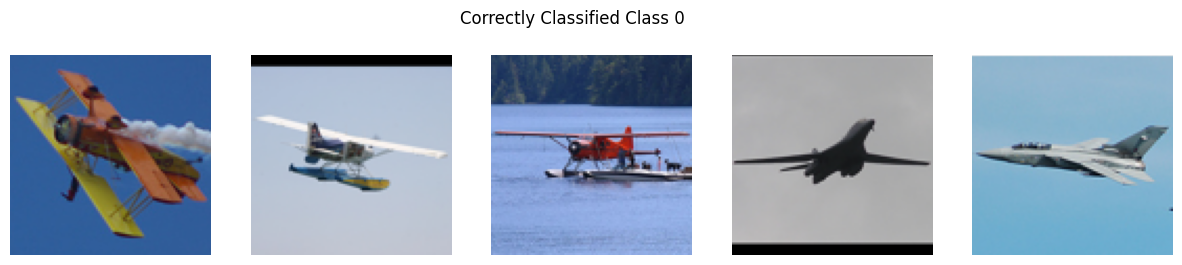

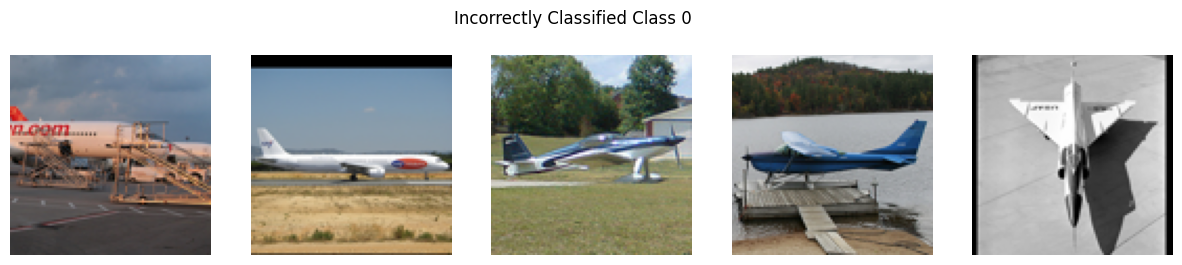

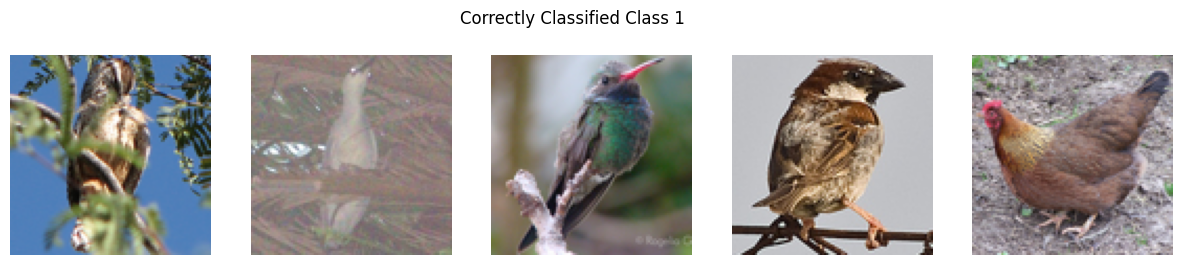

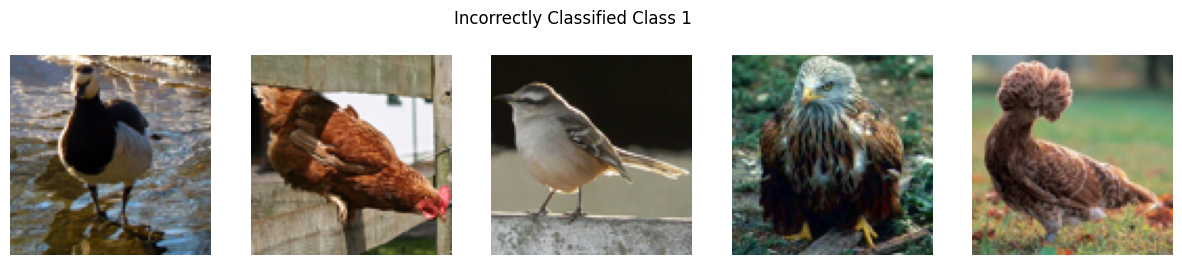

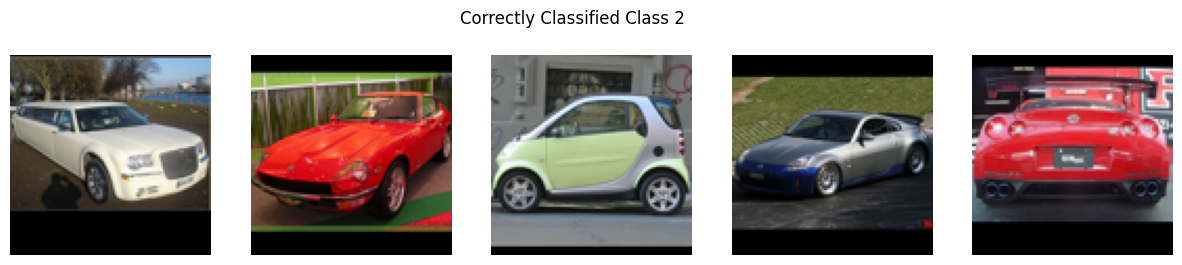

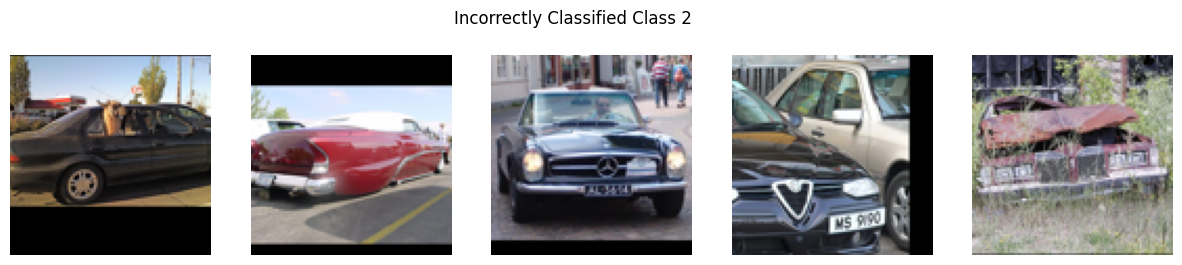

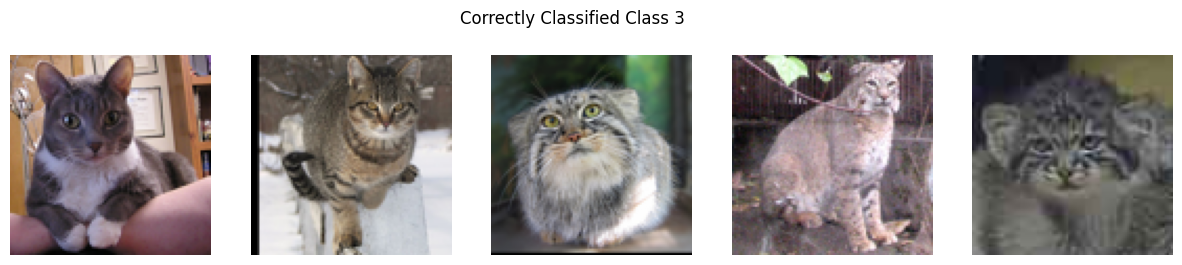

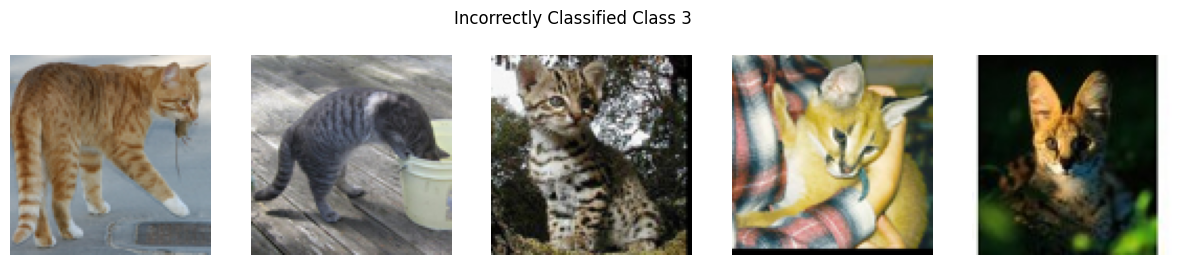

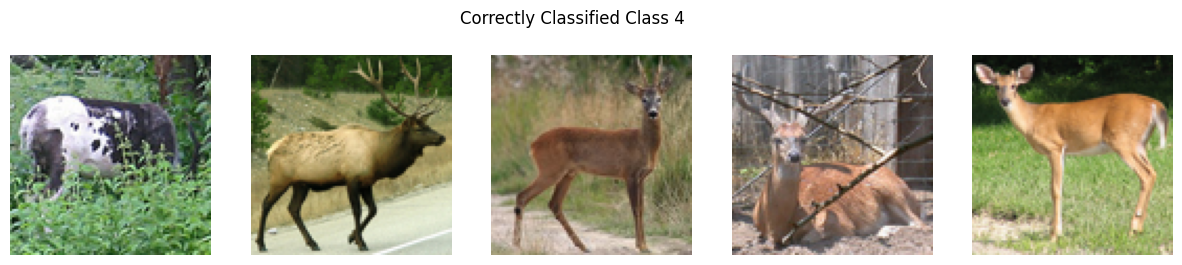

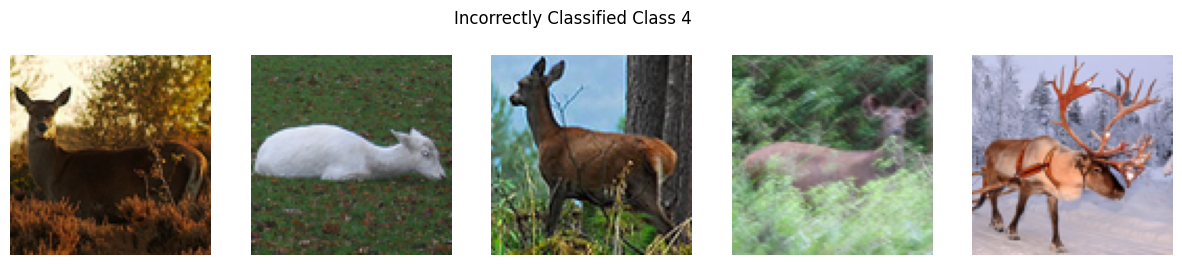

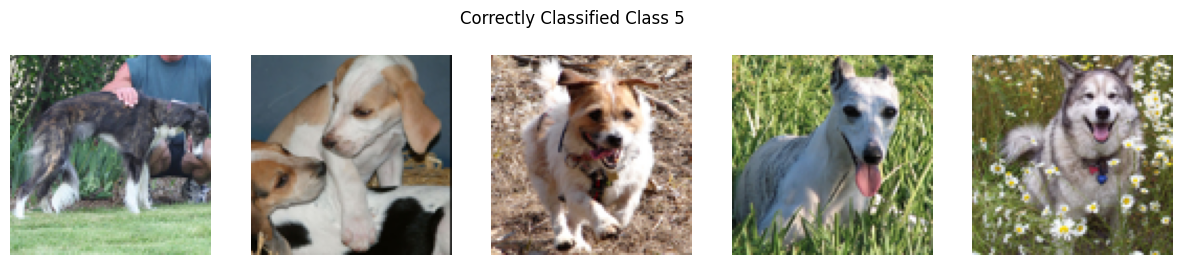

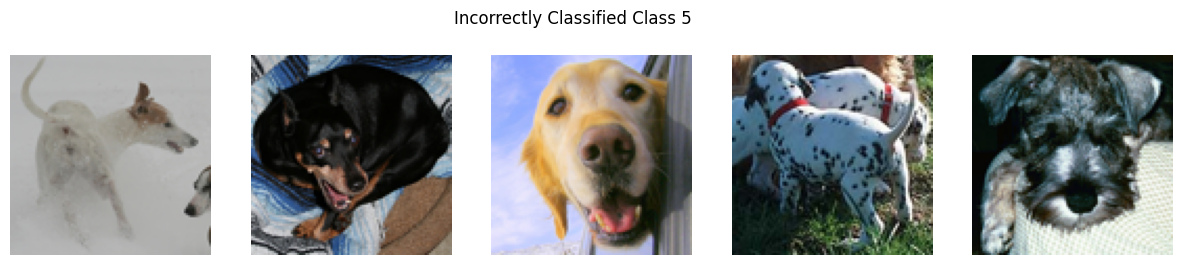

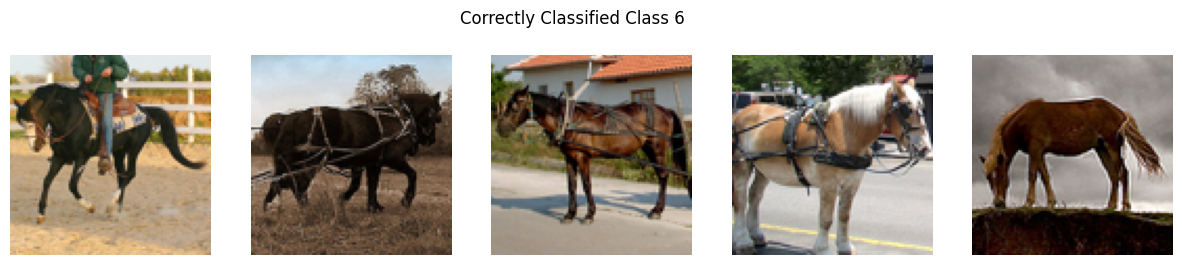

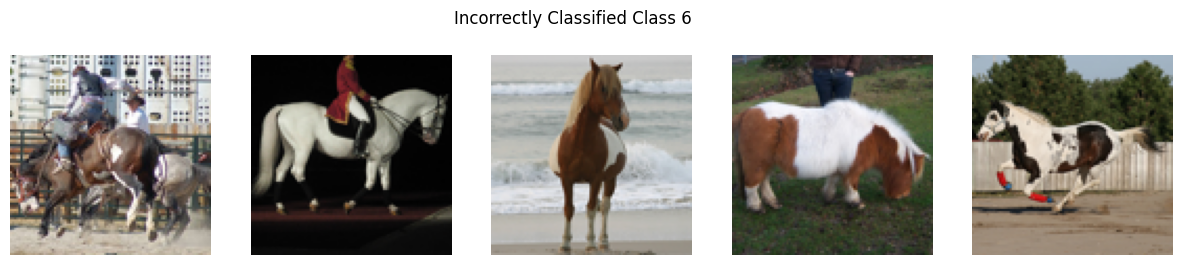

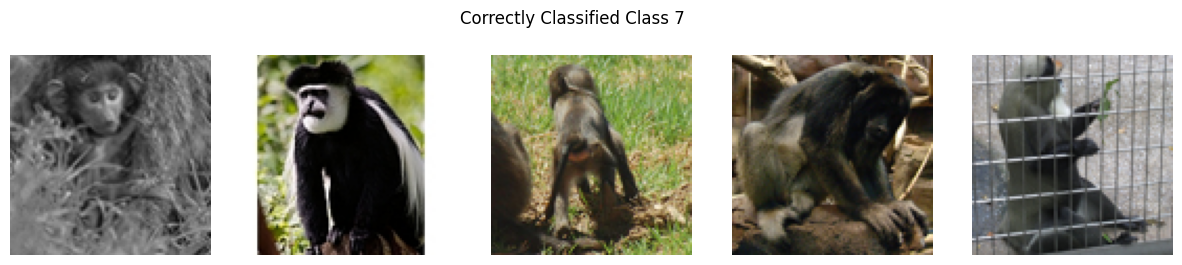

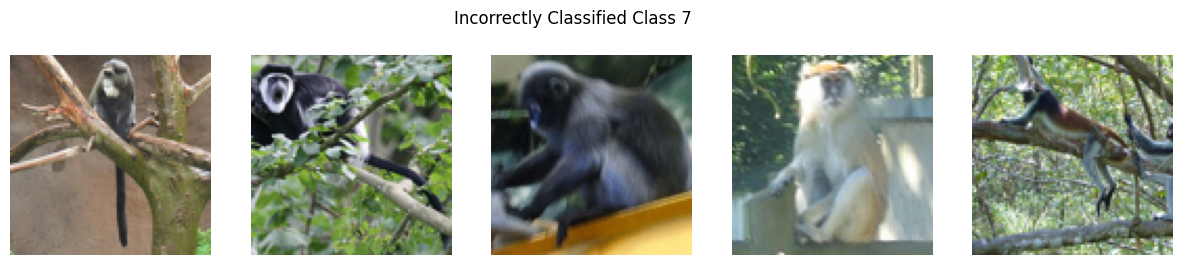

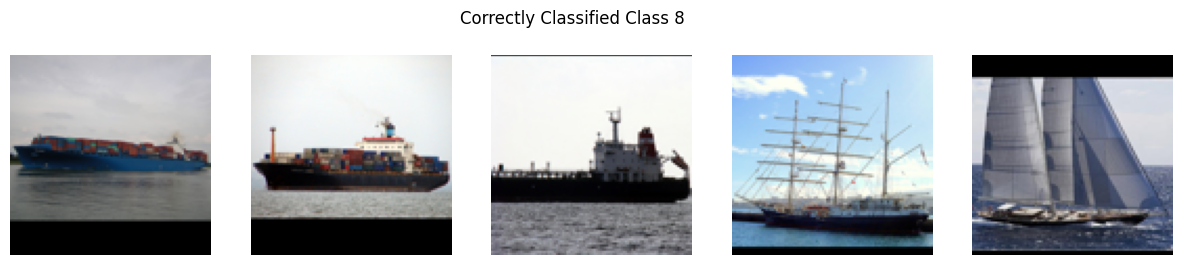

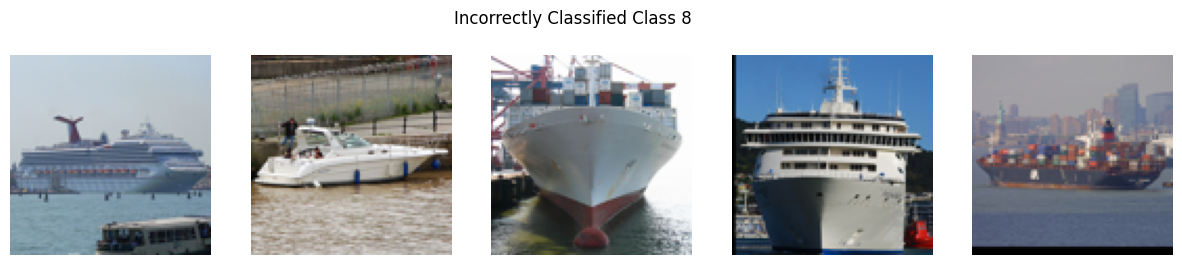

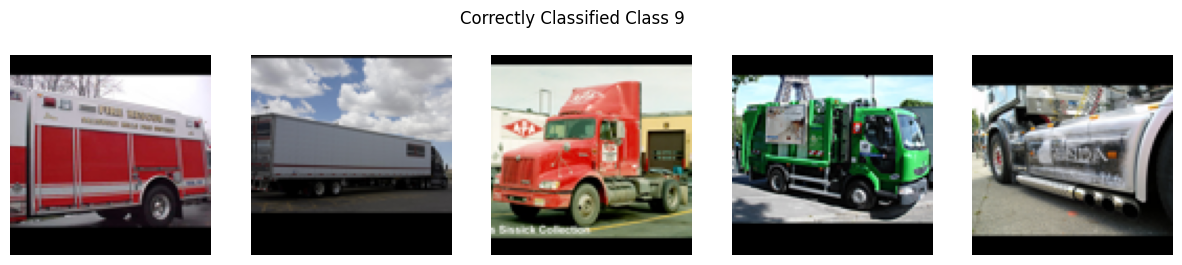

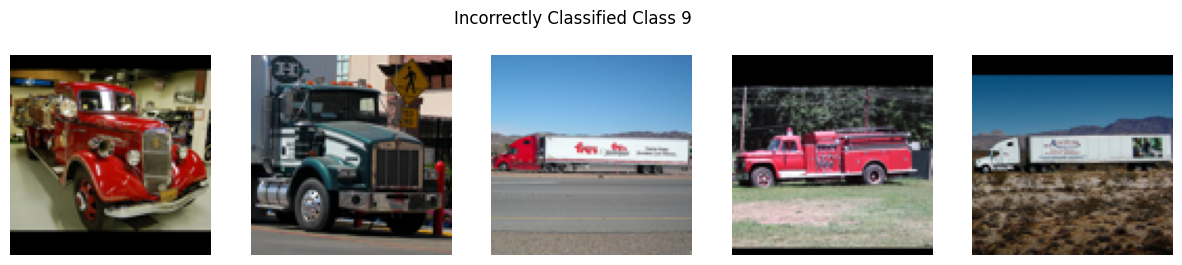

In [6]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correctly_classified = {i: [] for i in range(10)}
incorrectly_classified = {i: [] for i in range(10)}

model.eval()
val_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(data_module.test_dataloader()):
        data, labels = data.to("cuda"), labels.to("cuda")
        outputs = model(data)
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction, image in zip(labels, predicted, data):
            if label == prediction:
                class_correct[label] += 1
                correctly_classified[label.item()].append(image.cpu())
            else:
                incorrectly_classified[label.item()].append(image.cpu())
            class_total[label] += 1
for i in range(10):
    if class_total[i] > 0:
        print(f'Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%')

def show_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for img, ax in zip(images, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.suptitle(title)
    plt.grid
    plt.show()

for i in range(10):
    if correctly_classified[i]:
        show_images(correctly_classified[i][:5], f'Correctly Classified Class {i}')
    if incorrectly_classified[i]:
        show_images(incorrectly_classified[i][:5], f'Incorrectly Classified Class {i}')